In this notebook galaxies of different types atre distinguished. 

In [115]:
#standard libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.cm as cm
import sys
import os
#wcs is incompabible with newest numpy thus below not used 
#from astropy import wcs
#to access astronomical images in fits format
from astropy.io import fits
#torch functions
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
#sklearn helper functions
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score,f1_score, log_loss
#xgboost for comparison
from xgboost import XGBClassifier
#logistic regression for comparison 
from sklearn.linear_model import LogisticRegression


Now loading the data on the classification and other properties of the objects to be classified. 

In [116]:
df=pd.read_csv('Stripe82_1_zoo1b.csv',sep=',')
print(df.columns)

Index(['objid', 'ra', 'dec', 'psfMag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i',
       'psfMag_z', 'probPSF_u', 'probPSF_g', 'probPSF_r', 'probPSF_i',
       'probPSF_z', 'modelMag_u', 'modelMag_g', 'modelMag_r', 'modelMag_i',
       'modelMag_z', 'petroRad_g', 'petroRad_r', 'petroRad_i', 'run', 'rerun',
       'camcol', 'field', 'type', 'specobjid', 'class', 'subclass', 'redshift',
       'plate', 'mjd', 'fiberid', 'nvote', 'p_el', 'p_cw', 'p_acw', 'p_edge',
       'p_dk', 'p_mg', 'p_el_debiased', 'p_cs_debiased', 'spiral',
       'elliptical', 'uncertain'],
      dtype='object')


In [3]:
print(df['class'].value_counts())

GALAXY    461
QSO         5
Name: class, dtype: int64


In [4]:
print(df['subclass'].value_counts())

STARFORMING              143
STARBURST                 21
AGN                       18
BROADLINE                  8
STARFORMING BROADLINE      2
STARBURST BROADLINE        1
AGN BROADLINE              1
Name: subclass, dtype: int64


In [7]:
print(df['nvote'].value_counts().sort_index())

16     1
17     2
18     1
19     2
20     5
21     3
22     8
23    11
24     7
25    11
26    13
27    20
28    34
29    16
30    31
31    20
32    27
33    27
34    12
35    19
36    10
37    13
38     8
39     3
40     6
41     4
42     8
43     5
44     4
45     4
46     6
47     7
49     3
50     2
51     7
52     7
53     4
54     6
55     7
56     6
57     5
58     7
59    18
60     2
61     5
62     5
63     2
64     3
65     7
66     4
67     2
68     2
69     4
70     3
72     1
73     3
74     1
75     1
79     1
Name: nvote, dtype: int64


In [8]:
print(df['redshift'].describe())

count    466.000000
mean       0.105482
std        0.068600
min        0.020425
25%        0.049426
50%        0.102624
75%        0.140850
max        0.748432
Name: redshift, dtype: float64


In [12]:
print(df.iloc[:,34:42].columns)

Index(['p_el', 'p_cw', 'p_acw', 'p_edge', 'p_dk', 'p_mg', 'p_el_debiased',
       'p_cs_debiased'],
      dtype='object')


In [13]:
for i in range(34, 43):
    print(df.iloc[:,i].describe())

count    466.000000
mean       0.555440
std        0.279177
min        0.000000
25%        0.321000
50%        0.600000
75%        0.795250
max        1.000000
Name: p_el, dtype: float64
count    466.000000
mean       0.068227
std        0.164644
min        0.000000
25%        0.000000
50%        0.007000
75%        0.043000
max        1.000000
Name: p_cw, dtype: float64
count    466.000000
mean       0.076116
std        0.160698
min        0.000000
25%        0.000000
50%        0.020000
75%        0.069000
max        0.971000
Name: p_acw, dtype: float64
count    466.000000
mean       0.196697
std        0.206639
min        0.000000
25%        0.043500
50%        0.126000
75%        0.267000
max        1.000000
Name: p_edge, dtype: float64
count    466.000000
mean       0.077376
std        0.082146
min        0.000000
25%        0.019000
50%        0.058500
75%        0.108000
max        0.606000
Name: p_dk, dtype: float64
count    466.000000
mean       0.026034
std        0.082431
mi

In the numbers above clearly not all well classified, thus need further cleaning needed as input. I use the marker of elliptical, spiral for it. Other types like merger have not enough good classifications. That are two classes, a thord can be added when adding stars. 

In [28]:
df2=df[(df.spiral==1) | (df.elliptical==1) ]
print(df2.shape)
print(df.shape)
print(df2.elliptical.sum())
print(df2.spiral.sum())

(171, 48)
(466, 48)
59
112


There are 112 spiral and 59 elliptical in this data set. Likely not enough. For Now I figure out the sizez, get and save cutouts and later repeat with other data sets. 

In [17]:
def image_area(dat):
    ra_ref=dat[0].header['CRVAL1']
    ra_center=dat[0].header['CRPIX1']
    ra_scale=dat[0].header['CD1_1']
    dec_ref=dat[0].header['CRVAL2']
    dec_center=dat[0].header['CRPIX2']
    dec_scale=dat[0].header['CD2_2'] 
    image=dat[0].data
    res=np.array([[ra_ref+(1-ra_center)*ra_scale,ra_ref+(image.shape[0]-ra_center)*ra_scale],[dec_ref+(1-dec_center)*dec_scale,dec_ref+(image.shape[1]-dec_center)*dec_scale]])
    return res

In [18]:
def image_par(dat):
    ra_ref=dat[0].header['CRVAL1']
    ra_center=dat[0].header['CRPIX1']
    ra_scale=dat[0].header['CD1_1']
    dec_ref=dat[0].header['CRVAL2']
    dec_center=dat[0].header['CRPIX2']
    dec_scale=dat[0].header['CD2_2'] 
    par=np.array([ra_ref,ra_center,ra_scale,dec_ref,dec_center,dec_scale])
    return par

In [19]:
def image_xy(ra,dec,dat=0,par=0,image=True):
    #image is used input and the parameters are used
    if image==True:
        ra_ref=dat[0].header['CRVAL1']
        ra_center=dat[0].header['CRPIX1']
        ra_scale=dat[0].header['CD1_1']
        dec_ref=dat[0].header['CRVAL2']
        dec_center=dat[0].header['CRPIX2']
        dec_scale=dat[0].header['CD2_2'] 
    #paramter input    
    else:   
        ra_ref=par[0]
        ra_center=par[1]
        ra_scale=par[2]
        dec_ref=par[3]
        dec_center=par[4]
        dec_scale=par[5]
    #get the positions (pixels on image) 
    # the cosine part is only important if the image not close to the euqator 
    x=ra_center+(ra-ra_ref)/ra_scale*np.cos(dec/180*np.pi)
    y=dec_center+(dec-dec_ref)/dec_scale
    pixels=np.array([x,y])
    return pixels

In [20]:
path='/home/tobias/ml-testing/astr-images/'
list_input_files=[f for f in os.listdir(path) 
    if f.endswith('_rdeep.fits.gz') and os.path.isfile(os.path.join(path, f))]
list_input_files.sort()
print(list_input_files)

['f2001_rdeep.fits.gz', 'f2002_rdeep.fits.gz', 'f2003_rdeep.fits.gz', 'f2004_rdeep.fits.gz', 'f2005_rdeep.fits.gz', 'f2011_rdeep.fits.gz', 'f2012_rdeep.fits.gz', 'f2013_rdeep.fits.gz', 'f2014_rdeep.fits.gz', 'f2015_rdeep.fits.gz', 'f2021_rdeep.fits.gz', 'f2022_rdeep.fits.gz', 'f2023_rdeep.fits.gz', 'f2024_rdeep.fits.gz', 'f2025_rdeep.fits.gz', 'f2031_rdeep.fits.gz', 'f2032_rdeep.fits.gz', 'f2033_rdeep.fits.gz', 'f2034_rdeep.fits.gz', 'f2035_rdeep.fits.gz', 'f2041_rdeep.fits.gz', 'f2042_rdeep.fits.gz', 'f2043_rdeep.fits.gz', 'f2044_rdeep.fits.gz', 'f2045_rdeep.fits.gz', 'f2051_rdeep.fits.gz', 'f2052_rdeep.fits.gz', 'f2053_rdeep.fits.gz', 'f2054_rdeep.fits.gz', 'f2055_rdeep.fits.gz', 'f2061_rdeep.fits.gz', 'f2062_rdeep.fits.gz', 'f2063_rdeep.fits.gz', 'f2064_rdeep.fits.gz', 'f2065_rdeep.fits.gz']


In [21]:
centers=np.zeros((2,len(list_input_files)))
wcs_par=np.zeros((6,len(list_input_files)))
for i in range(len(list_input_files)):
    print(i)
    #get images
    hbin=fits.open(path+list_input_files[i],memmap=True)
    #get parameters wanted 
    res=image_area(hbin)
    par=image_par(hbin)
    hbin.close()
    centers[0,i]=(res[0,0]+res[0,1])/2  #center is avarage of extension in both dimensions
    centers[1,i]=(res[1,0]+res[1,1])/2
    #parameters to find objects on images
    wcs_par[:,i]=par
print(centers)  


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
[[ 4.97500000e+01  4.97500000e+01  4.97500000e+01  4.97500000e+01
   4.97500000e+01  5.02500000e+01  5.02500000e+01  5.02500000e+01
   5.02500000e+01  5.02500000e+01  5.07500000e+01  5.07500000e+01
   5.07500000e+01  5.07500000e+01  5.07500000e+01  5.12500000e+01
   5.12500000e+01  5.12500000e+01  5.12500000e+01  5.12500000e+01
   5.17500000e+01  5.17500000e+01  5.17500000e+01  5.17500000e+01
   5.17500000e+01  5.22500000e+01  5.22500000e+01  5.22500000e+01
   5.22500000e+01  5.22500000e+01  5.27500000e+01  5.27500000e+01
   5.27500000e+01  5.27500000e+01  5.27500000e+01]
 [-1.00000000e+00 -5.00000000e-01 -1.08246745e-15  5.00000000e-01
   1.00000000e+00 -1.00000000e+00 -5.00000000e-01 -1.08246745e-15
   5.00000000e-01  1.00000000e+00 -1.00000000e+00 -5.00000000e-01
  -1.08246745e-15  5.00000000e-01  1.00000000e+00 -1.00000000e+00
  -5.00000000e-01 -1.08246745e-15  5.00000000e-01  1.00000000e

In [38]:

# I add dummy columns which are later filter with the image and the pixels positions on it for all onbjects
df2['image']=-1
df2['pixel_x']=-1.0
df2['pixel_y']=-1.0
print(df2.columns)

Index(['objid', 'ra', 'dec', 'psfMag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i',
       'psfMag_z', 'probPSF_u', 'probPSF_g', 'probPSF_r', 'probPSF_i',
       'probPSF_z', 'modelMag_u', 'modelMag_g', 'modelMag_r', 'modelMag_i',
       'modelMag_z', 'petroRad_g', 'petroRad_r', 'petroRad_i', 'run', 'rerun',
       'camcol', 'field', 'type', 'specobjid', 'class', 'subclass', 'redshift',
       'plate', 'mjd', 'fiberid', 'nvote', 'p_el', 'p_cw', 'p_acw', 'p_edge',
       'p_dk', 'p_mg', 'p_el_debiased', 'p_cs_debiased', 'spiral',
       'elliptical', 'uncertain', 'image', 'pixel_x', 'pixel_y'],
      dtype='object')


/tmp/ipykernel_14412/1108359313.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['image']=-1
/tmp/ipykernel_14412/1108359313.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['pixel_x']=-1.0
/tmp/ipykernel_14412/1108359313.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

In [117]:
for i in range(df2.shape[0]):
    #distances to all images ceneters
    r=np.sqrt((df2['ra'].iloc[i]-centers[0])**2+(df2['dec'].iloc[i]-centers[1])**2)
    #id of the image
    df2['image'].iloc[i]=np.argmin(r)
    #get pixel coordinates of image 
    coor=image_xy(df2['ra'].iloc[i],df2['dec'].iloc[i],par=wcs_par[:,df2['image'].iloc[i]],image=False)
    df2['pixel_x'].iloc[i]=coor[0]
    df2['pixel_y'].iloc[i]=coor[1]

SyntaxError: expression cannot contain assignment, perhaps you meant "=="? (2209389875.py, line 7)

In [42]:
print(df.image.value_counts().sort_index(0))
print(df.pixel_x.describe())
print(df.pixel_y.describe())

5     12
6      5
7     21
8     14
9     16
10    15
11    18
12    22
13    30
14    16
15    13
16    27
17    27
18     7
19    12
20    25
21    35
22    15
23    14
24     8
25    26
26    41
27    16
28    19
29    12
Name: image, dtype: int64
count     466.000000
mean     2272.185116
std      1313.327255
min         8.482406
25%      1025.809866
50%      2242.541470
75%      3364.450051
max      4536.568744
Name: pixel_x, dtype: float64
count     466.000000
mean     2147.574934
std      1279.945887
min        10.193603
25%      1077.989496
50%      2020.252412
75%      3235.390737
max      4570.496224
Name: pixel_y, dtype: float64


/tmp/ipykernel_14412/1747985613.py:1: FutureWarning: In a future version of pandas all arguments of Series.sort_index will be keyword-only.
  print(df.image.value_counts().sort_index(0))


In [43]:
df2=df2.sort_values(by='image')
#reset index since the previous row is not wanted 
df2=df2.reset_index()
print(df2.head)

<bound method NDFrame.head of      index                objid         ra       dec  psfMag_u  psfMag_g  \
0        1  1237663237128388701  50.130513 -1.228488  22.01211  20.06700   
1      123  1237666299481817102  50.160628 -1.035026  19.01124  17.46116   
2      140  1237663237128388949  50.167304 -1.241885  22.36878  20.17246   
3      458  1237666300018557091  50.006004 -0.495751  21.98376  19.93291   
4      110  1237663238739067202  50.387910  0.198944  21.86834  19.78908   
..     ...                  ...        ...       ...       ...       ...   
166    435  1237660241925374126  52.442772  0.981833  20.40372  18.25091   
167    171  1237660241925242993  52.138302  1.006711  20.15088  18.13022   
168    138  1237666301630087349  52.010896  0.750651  20.99527  19.11591   
169    355  1237666301630152896  52.116443  0.782111  23.48243  20.96860   
170    108  1237666301630087374  52.057037  0.808168  22.29056  20.49410   

     psfMag_r  psfMag_i  psfMag_z  probPSF_u  ...   p_dk 

In [47]:
def get_cutouts(df,delta):
    #collected array
    c=0
    cut_outs=np.zeros((2*delta+1,2*delta+1,df.shape[0]))
    #parameter to indicate whether an image exist. 
    df['off_image']=False
    for i in range(df.shape[0]):
        #image loaded if first image
        if i==0:
            #load file
            hbin=fits.open(path+list_input_files[df.image.iloc[i]])
            #get image, need to be transposed because of difefrent definitions in astronomy and numpy on what is the first axis
            image=hbin[0].data.T
        else:
            #or if new image
            if df.image.iloc[i]!=df.image.iloc[i-1]:
                hbin=fits.open(path+list_input_files[df.image.iloc[i]])
                #need to be transposed because of difefrent definitions in astronomy and numpy on what is the first axis
                image=hbin[0].data.T  
        #gfigure out if within image borders  then cut out image is collected       
        if round(df.pixel_x.iloc[i])>delta and round(df.pixel_x.iloc[i])<image.shape[0]-delta and  round(df.pixel_y.iloc[i])>delta and round(df.pixel_y.iloc[i])<image.shape[1]-delta:
            cut_outs[:,:,i]=image[round(df.pixel_x.iloc[i])-delta:round(df.pixel_x.iloc[i])+delta+1,round(df.pixel_y.iloc[i])-delta:round(df.pixel_y.iloc[i])+delta+1]
        else:
            #if not marker column set to true
            print(f"row {i} is off the image")
            df['off_image'].iloc[i]=True
            c+=1
    print(f"{c} objects are off the image")        
    return df, cut_outs       

In [57]:
df2,cut_out=get_cutouts(df2,21)

row 26 is off the image


/tmp/ipykernel_14412/1042212200.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['off_image'].iloc[i]=True


row 135 is off the image
row 168 is off the image
3 objects are off the image


In [58]:
print(df2.spiral.sum(),df2.spiral)

112 0      0
1      0
2      0
3      0
4      0
      ..
166    0
167    0
168    0
169    1
170    1
Name: spiral, Length: 171, dtype: int64


In [56]:
print(df2.petroRad_r.describe()/0.396)

count    431.818182
mean      18.713942
std       14.905279
min        6.393654
25%       11.897563
50%       15.543955
75%       20.852159
max      172.496768
Name: petroRad_r, dtype: float64


Using 75% of the Petrosian radius as estimate of needed size. 

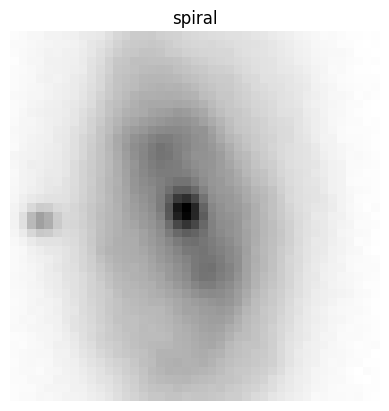

In [61]:
plt.axis('off')
plt.title("spiral")
plt.imshow(1-cut_out[:,:,170].T,cmap=cm.gray, interpolation='nearest')

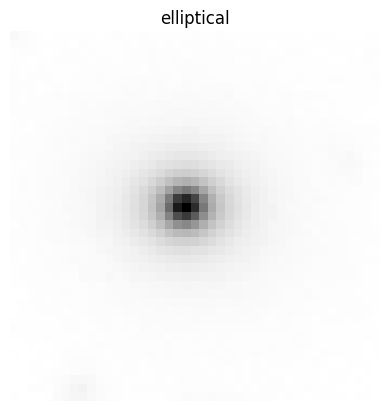

In [62]:
plt.axis('off')
plt.title("elliptical")
plt.imshow(1-cut_out[:,:,0].T,cmap=cm.gray, interpolation='nearest')

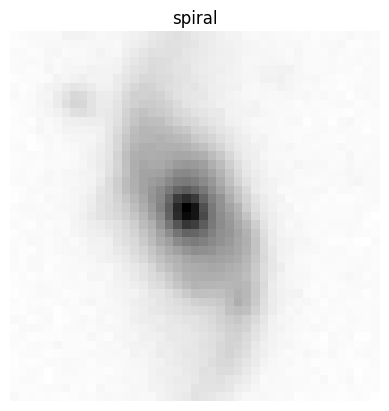

In [63]:
plt.axis('off')
plt.title("spiral")
plt.imshow(1-cut_out[:,:,169].T,cmap=cm.gray, interpolation='nearest')

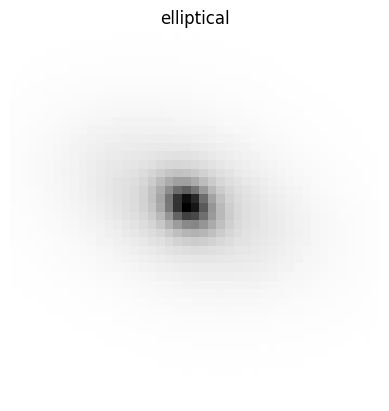

In [64]:
plt.axis('off')
plt.title("elliptical")
plt.imshow(1-cut_out[:,:,1].T,cmap=cm.gray, interpolation='nearest')

Now looking on the most extreme cases, whether they look o.k. per eye. 

In [80]:
maxr=np.argsort(-df2.petroRad_r)
for i in range(10):
    print(maxr[i])
    print(df2.petroRad_r[maxr[i]],df2.spiral[maxr[i]])

79
68.30872 0
39
25.19113 1
86
19.36722 1
167
17.54918 0
52
17.13827 1
69
16.60319 1
82
16.38569 1
106
16.36477 1
8
16.35131 1
157
14.50623 1


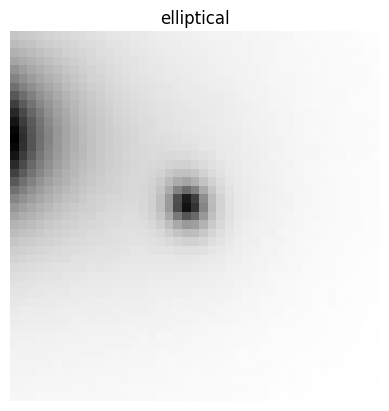

In [81]:
#can be seen, problem is neighbor 
plt.axis('off')
plt.title("elliptical")
plt.imshow(1-cut_out[:,:,79].T,cmap=cm.gray, interpolation='nearest')

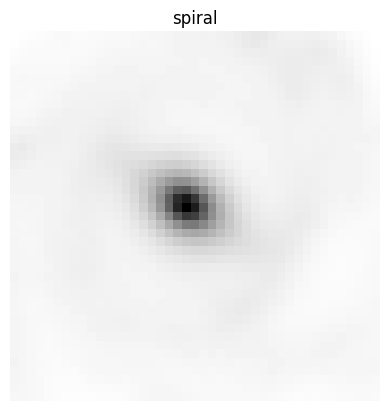

In [82]:
#can be seen
plt.axis('off')
plt.title("spiral")
plt.imshow(1-cut_out[:,:,39].T,cmap=cm.gray, interpolation='nearest')

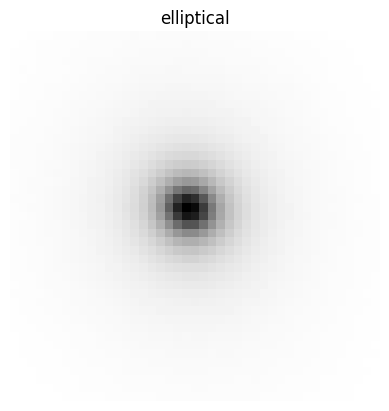

In [83]:
plt.axis('off')
plt.title("elliptical")
plt.imshow(1-cut_out[:,:,167].T,cmap=cm.gray, interpolation='nearest')

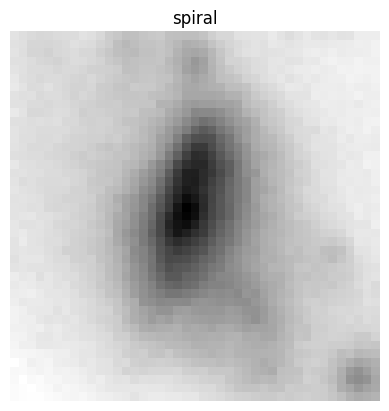

In [84]:
plt.axis('off')
plt.title("spiral")
plt.imshow(1-cut_out[:,:,86].T,cmap=cm.gray, interpolation='nearest')

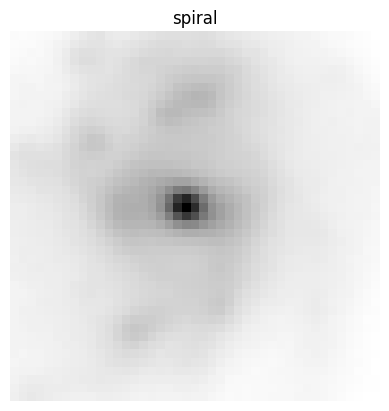

In [85]:
plt.axis('off')
plt.title("spiral")
plt.imshow(1-cut_out[:,:,52].T,cmap=cm.gray, interpolation='nearest')

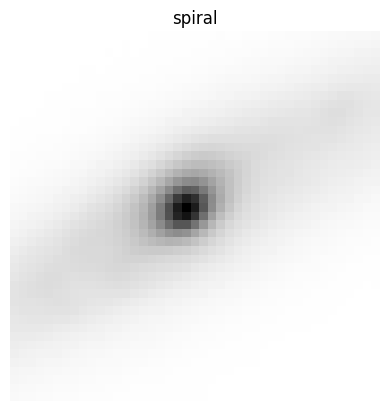

In [86]:
#likely not all on but rather clear spiral 
plt.axis('off')
plt.title("spiral")
plt.imshow(1-cut_out[:,:,69].T,cmap=cm.gray, interpolation='nearest')

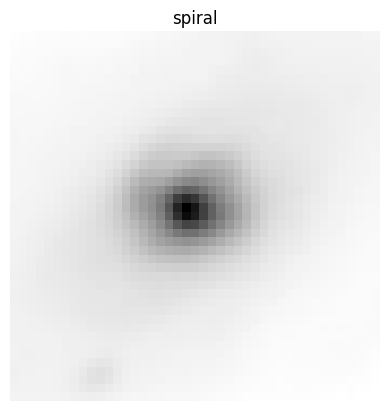

In [87]:
plt.axis('off')
plt.title("spiral")
plt.imshow(1-cut_out[:,:,82].T,cmap=cm.gray, interpolation='nearest')

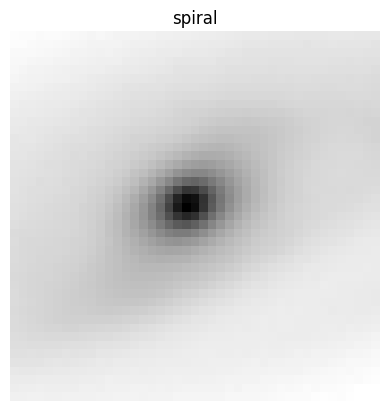

In [93]:
#needed scaling to see the structure 
plt.axis('off')
plt.title("spiral")
plt.imshow(-np.sqrt(cut_out[:,:,106]).T,cmap=cm.gray, interpolation='nearest')

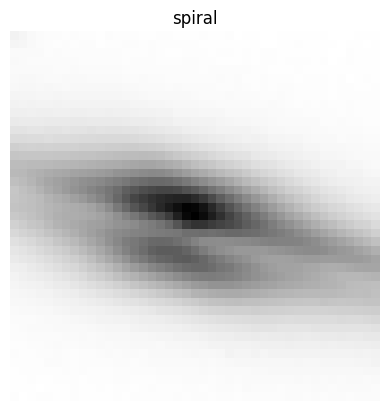

In [89]:
#not fully on it, but clear 
plt.axis('off')
plt.title("spiral")
plt.imshow(1-cut_out[:,:,8].T,cmap=cm.gray, interpolation='nearest')

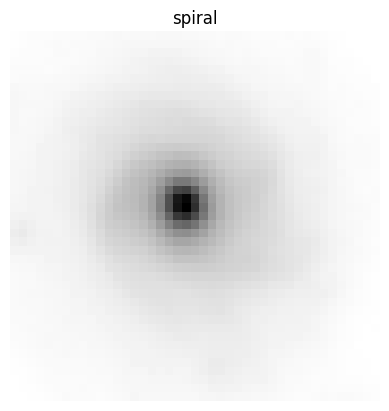

In [90]:
plt.axis('off')
plt.title("spiral")
plt.imshow(1-cut_out[:,:,157].T,cmap=cm.gray, interpolation='nearest')

Look good in general, there more structure visible for the spiral as it should be, while elliptical are smooth.


In [101]:
df3=df2[df2.off_image==False]
#new image array, to which also a 4 dimension of zero size is added 
cut_out2=np.zeros((cut_out.shape[0],cut_out.shape[1],1,df3.shape[0]))
counter=0
for i in range(df2.shape[0]):
    if df2.off_image.iloc[i]==False:
        #adding the cut outs not of image
        cut_out2[:,:,0,counter]=cut_out[:,:,i]
        counter+=1
np.save("stripe82_1_ell_spiral_im.npy",cut_out2)    
df3.to_csv('stripe82_1_ell_spiral_table.csv') 

3    168
Name: type, dtype: int64


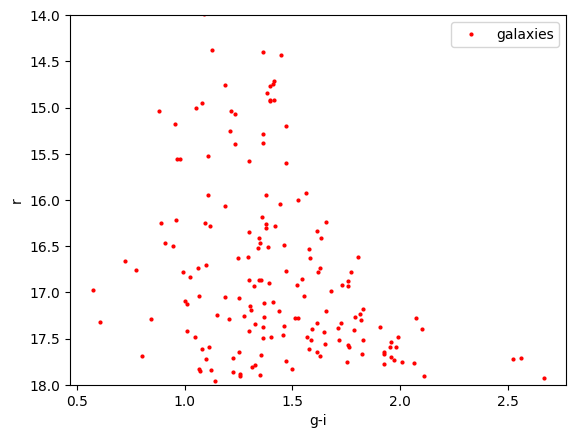

In [114]:
plt.plot(df3['modelMag_g']-df3['modelMag_i'],df3['modelMag_r'],'o',ms=2,color='red',label='galaxies') 
plt.legend(loc="best")
plt.xlabel("g-i")
plt.ylabel("r")
plt.ylim(18,14)
#plt.yscale("log")
print(df3['type'].value_counts())

In [103]:
test=np.load('stripe82_1_ell_spiral_im.npy')
print(test.shape)
df4=pd.read_csv('stripe82_1_ell_spiral_table.csv')
print(df4.columns)

(43, 43, 1, 168)
Index(['Unnamed: 0', 'index', 'objid', 'ra', 'dec', 'psfMag_u', 'psfMag_g',
       'psfMag_r', 'psfMag_i', 'psfMag_z', 'probPSF_u', 'probPSF_g',
       'probPSF_r', 'probPSF_i', 'probPSF_z', 'modelMag_u', 'modelMag_g',
       'modelMag_r', 'modelMag_i', 'modelMag_z', 'petroRad_g', 'petroRad_r',
       'petroRad_i', 'run', 'rerun', 'camcol', 'field', 'type', 'specobjid',
       'class', 'subclass', 'redshift', 'plate', 'mjd', 'fiberid', 'nvote',
       'p_el', 'p_cw', 'p_acw', 'p_edge', 'p_dk', 'p_mg', 'p_el_debiased',
       'p_cs_debiased', 'spiral', 'elliptical', 'uncertain', 'image',
       'pixel_x', 'pixel_y', 'off_image'],
      dtype='object')


     index                objid         ra       dec  psfMag_u  psfMag_g  \
0        1  1237663237128388701  50.130513 -1.228488  22.01211  20.06700   
1      123  1237666299481817102  50.160628 -1.035026  19.01124  17.46116   
2      140  1237663237128388949  50.167304 -1.241885  22.36878  20.17246   
3      458  1237666300018557091  50.006004 -0.495751  21.98376  19.93291   
4      110  1237663238739067202  50.387910  0.198944  21.86834  19.78908   
..     ...                  ...        ...       ...       ...       ...   
165    228  1237660241388306584  52.065544  0.492483  22.05364  19.92814   
166    435  1237660241925374126  52.442772  0.981833  20.40372  18.25091   
167    171  1237660241925242993  52.138302  1.006711  20.15088  18.13022   
169    355  1237666301630152896  52.116443  0.782111  23.48243  20.96860   
170    108  1237666301630087374  52.057037  0.808168  22.29056  20.49410   

     psfMag_r  psfMag_i  psfMag_z  probPSF_u  ...   p_mg  p_el_debiased  \
0    18.8685